In [13]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import nibabel as nib
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision

In [ ]:
# Path to your NIfTI file
nii_file_path = r"F:\Task1_val\Task1\brain\1BA034\mr.nii"

# Load the NIfTI file
nii_image = nib.load(nii_file_path)

# Get the data from the NIfTI file
image_data = nii_image.get_fdata()

# Now you can process or analyze the image data
print(image_data.shape)


In [ ]:
# Assuming image_data is your 3D NIfTI image data
# Calculate the middle index along each dimension
mid_x = image_data.shape[0] // 2
mid_y = image_data.shape[1] // 2
mid_z = image_data.shape[2] // 2

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Axial slice (X-Y plane)
ax[0].imshow(image_data[:, :, mid_z], cmap='gray')
ax[0].set_title('Axial Slice')

# Coronal slice (X-Z plane)
ax[1].imshow(image_data[:, mid_y, :], cmap='gray')
ax[1].set_title('Coronal Slice')

# Sagittal slice (Y-Z plane)
ax[2].imshow(image_data[mid_x, :, :], cmap='gray')
ax[2].set_title('Sagittal Slice')

# Display the plots
plt.show()


In [ ]:
def process_and_save_middle_slices(input_folder, output_folder, patient_id):
    # File paths
    mri_path = os.path.join(input_folder, patient_id, 'mr.nii')
    ct_path = os.path.join(input_folder, patient_id, 'ct.nii')
    mask_path = os.path.join(input_folder, patient_id, 'mask.nii')

    # Load images
    mri_image = nib.load(mri_path).get_fdata()
    ct_image = nib.load(ct_path).get_fdata()
    mask_image = nib.load(mask_path).get_fdata()

    # Calculate the middle index along each dimension
    mid_x = mri_image.shape[0] // 2
    mid_y = mri_image.shape[1] // 2
    mid_z = mri_image.shape[2] // 2

    # Extract the middle slices
    axial_slices = {
        'mri': mri_image[:, :, mid_z],
        'ct': ct_image[:, :, mid_z],
        'mask': mask_image[:, :, mid_z],
    }
    coronal_slices = {
        'mri': mri_image[:, mid_y, :],
        'ct': ct_image[:, mid_y, :],
        'mask': mask_image[:, mid_y, :],
    }
    sagittal_slices = {
        'mri': mri_image[mid_x, :, :],
        'ct': ct_image[mid_x, :, :],
        'mask': mask_image[mid_x, :, :],
    }

    # Create directories if they don't exist
    middle_slice_folder = os.path.join(output_folder, patient_id, 'middle_slices')
    os.makedirs(middle_slice_folder, exist_ok=True)

    # Save the middle slices
    for slice_type, slices in zip(['axial', 'coronal', 'sagittal'], [axial_slices, coronal_slices, sagittal_slices]):
        for modality, slice_data in slices.items():
            plt.imsave(os.path.join(middle_slice_folder, f'{modality}_{slice_type}.png'), slice_data, cmap='gray')



In [ ]:
input_folder = r'F:\Task1\Task1\brain'
output_folder = r'F:\new_dataset\brain'

# List patient folders
patient_ids = [folder for folder in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, folder))]
for patient_id in patient_ids:
    process_and_save_middle_slices(input_folder, output_folder, patient_id)

In [2]:
class MedicalImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Assuming subdirectories are structured as patient_id/middle_slices/...
        self.patients = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        
    def __len__(self):
        # Assuming each patient has 3 middle slices for MRI, CT, and mask
        return len(self.patients) * 3

    def __getitem__(self, idx):
        patient_id = self.patients[idx // 3]  # Integer division to group every three slices
        slice_type = ['axial', 'coronal', 'sagittal'][idx % 3]  # Modulo to cycle through slice types
        
        mri_path = os.path.join(self.root_dir, patient_id, 'middle_slices', f'mri_{slice_type}.png')
        ct_path = os.path.join(self.root_dir, patient_id, 'middle_slices', f'ct_{slice_type}.png')
        mask_path = os.path.join(self.root_dir, patient_id, 'middle_slices', f'mask_{slice_type}.png')

        mri_image = Image.open(mri_path).convert('L')  # Convert to grayscale
        ct_image = Image.open(ct_path).convert('L')  # Convert to grayscale
        mask_image = Image.open(mask_path).convert('L')  # Convert to grayscale

        if self.transform:
            mri_image = self.transform(mri_image)
            ct_image = self.transform(ct_image)
            mask_image = self.transform(mask_image)

        return mri_image, ct_image, mask_image


In [36]:

# Define a transform if you need to preprocess the image
# For example, to convert images to PyTorch tensors
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    # Add other transformations here
])

# Instantiate the dataset
medical_dataset = MedicalImageDataset(root_dir=r'F:\new_dataset\brain', transform=transform)

# Create a DataLoader
dataloader = DataLoader(medical_dataset, batch_size=1, shuffle=True, num_workers=0)
del medical_dataset

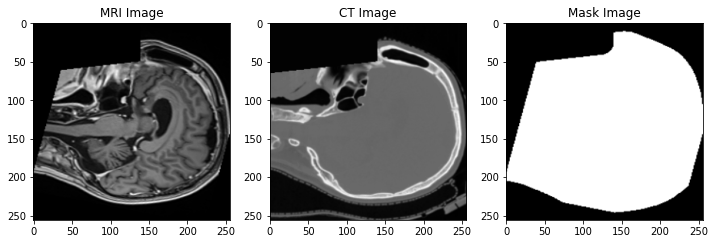

In [24]:
first_batch = next(iter(dataloader))

# Unpack the first batch
mri, ct, mask = first_batch

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(mri[0].squeeze(), cmap='gray')
ax[0].set_title('MRI Image')
ax[1].imshow(ct[0].squeeze(), cmap='gray')
ax[1].set_title('CT Image')
ax[2].imshow(mask[0].squeeze(), cmap='gray')
ax[2].set_title('Mask Image')
plt.show()

In [25]:
import torch.nn as nn
import torch.nn.functional as F
# Define a simple convolutional block
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Define a simple Convolutional Neural Network for MRI to CT image translation
class MRIToCTModel(nn.Module):
    def __init__(self):
        super(MRIToCTModel, self).__init__()
        # Encoder: Compressing the MRI image into feature representations
        self.encoder = nn.Sequential(
            conv_block(1, 64),  # 256x256 -> 256x256
            nn.MaxPool2d(2),   # 256x256 -> 128x128
            conv_block(64, 128),
            nn.MaxPool2d(2),   # 128x128 -> 64x64
            conv_block(128, 256),
            nn.MaxPool2d(2),   # 64x64 -> 32x32
        )
        # Decoder: Reconstructing the CT image from the feature representations
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),  # 32x32 -> 64x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 2, stride=2),   # 64x64 -> 128x128
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, 2, stride=2),     # 128x128 -> 256x256
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create the model instance
model = MRIToCTModel()

# Print the model summary for inspection
print(model)

MRIToCTModel(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
 

In [27]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define your model and move it to the device
model = MRIToCTModel().to(device)

# Define your loss function
criterion = torch.nn.MSELoss()

# Assume optimizer is defined
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for mri_images, ct_images, masks in dataloader:
        # Move data to the device
        mri_images = mri_images.to(device)
        ct_images = ct_images.to(device)
        masks = masks.to(device)

        # Forward pass through the model to get the predicted CT images
        pred_ct_images = model(mri_images)

        # Apply the mask to focus the loss on the region of interest
        masked_pred_ct = pred_ct_images * masks
        masked_ct_images = ct_images * masks

        # Calculate the loss only within the masked region
        loss = criterion(masked_pred_ct, masked_ct_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Using device: cuda
Epoch [1/100], Loss: 0.01342543214559555
Epoch [2/100], Loss: 0.011470144614577293
Epoch [3/100], Loss: 0.010395020246505737
Epoch [4/100], Loss: 0.010357961058616638
Epoch [5/100], Loss: 0.00933421216905117
Epoch [6/100], Loss: 0.008398191072046757
Epoch [7/100], Loss: 0.008440516889095306
Epoch [8/100], Loss: 0.008061027154326439
Epoch [9/100], Loss: 0.008204244077205658
Epoch [10/100], Loss: 0.007999507710337639
Epoch [11/100], Loss: 0.008662458509206772
Epoch [12/100], Loss: 0.008666778914630413
Epoch [13/100], Loss: 0.008249764330685139
Epoch [14/100], Loss: 0.008563606068491936
Epoch [15/100], Loss: 0.007624510675668716
Epoch [16/100], Loss: 0.007938123308122158
Epoch [17/100], Loss: 0.0068752700462937355
Epoch [18/100], Loss: 0.00751074543222785
Epoch [19/100], Loss: 0.007808745373040438
Epoch [20/100], Loss: 0.00808375608175993
Epoch [21/100], Loss: 0.007791147101670504
Epoch [22/100], Loss: 0.007146521471440792
Epoch [23/100], Loss: 0.006716851145029068
Epoc

In [37]:
first_batch = next(iter(dataloader))

# Unpack the first batch
mri, ct, mask = first_batch

In [48]:
mri_images =  mri.to(device)
pred_ct_images = model(mri_images)

In [39]:
pred_ct_images = torchvision.transforms.ToPILImage()(pred_ct_images[0])

In [41]:
scaler = lambda x: np.exp(x)

In [44]:
import numpy as np

In [54]:
s = scaler(prd)

In [52]:
prd = pred_ct_images.cpu().detach().numpy()

In [57]:
s[0]

array([[[1.1270659, 1.0716332, 1.1445578, ..., 1.0954944, 1.0898638,
         1.0575783],
        [1.1418808, 1.1463827, 1.1583759, ..., 1.0641139, 1.037023 ,
         1.0576972],
        [1.1546549, 1.1601374, 1.1584895, ..., 1.0929663, 1.044429 ,
         1.0640264],
        ...,
        [1.1812496, 1.130508 , 1.2179873, ..., 1.1969464, 1.1568818,
         1.1856705],
        [1.1367756, 1.1767433, 1.2220842, ..., 1.128168 , 1.1715525,
         1.1943921],
        [1.1524425, 1.1956427, 1.1937616, ..., 1.1588066, 1.1393744,
         1.1697208]]], dtype=float32)

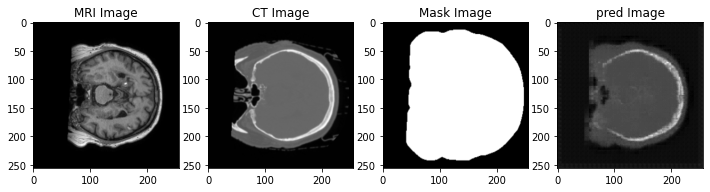

In [59]:
# Plot the images
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(mri[0].squeeze(), cmap='gray')
ax[0].set_title('MRI Image')
ax[1].imshow(ct[0].squeeze(), cmap='gray')
ax[1].set_title('CT Image')
ax[2].imshow(mask[0].squeeze(), cmap='gray')
ax[2].set_title('Mask Image')
ax[3].imshow(s[0].squeeze(), cmap='gray')
ax[3].set_title('pred Image')
plt.show()